In [1]:
import pyccl as ccl
import numpy as np
from scipy.integrate import simps
import matplotlib.pyplot as plt

In [2]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 16
mpl.rcParams['text.usetex'] = 'True'

In [3]:
cosmo = ccl.CosmologyVanillaLCDM()

# Here we use a mass definition with Delta = 200 times the matter density,
hmd_200m = ccl.halos.MassDef200m()
# the Duffy 2008 concentration-mass relation,
cM = ccl.halos.ConcentrationDuffy08(hmd_200m)

In [4]:
class CacciatoHOD(ccl.halos.HaloProfileHOD):
    def __init__(self, c_M_relation,
                 Lmin, Lmax, N_L=64,
                 lL_0=9.95, lM_1=11.24,
                 gamma_1=3.18, gamma_2=0.245,
                 sigma_c=0.157, alpha_s=-1.18,
                 b_0=-1.17, b_1=1.53*0.739, b_2=-0.217*0.739**2,
                 fh=1., fs=1.):
        # fh, fs the scaling of c_M_relation, to be include in _usat_real/fourier
        # b_1 and b_2 have been rescaled by h from Cacciato et al. 2013
        self.cM = c_M_relation

        self.Lmin = Lmin
        self.Lmax = Lmax
        self.N_L = N_L
        self.L_arr = np.geomspace(self.Lmin, self.Lmax, self.N_L)

        self.lL_0 = lL_0
        self.L_0 = 10**lL_0
        self.lM_1 = lM_1
        self.M_1 = 10**lM_1
        self.gamma_1 = gamma_1
        self.gamma_2 = gamma_2
        self.sigma_c = sigma_c
        self.alpha_s = alpha_s
        self.b_0 = b_0
        self.b_1 = b_1
        self.b_2 = b_2
        self.loge = 0.4342944819 # logarithm of e

        # TODO: Do I need to do this?
        super(ccl.halos.HaloProfileHOD, self).__init__()

    def _Lc(self, M):
        return self.L_0 * (M/self.M_1) ** self.gamma_1 /\
               (1+(M/self.M_1)**(self.gamma_1-self.gamma_2))

    def _phi_star_s(self, M):
        M12 = M/10**12 # In solar masses
        log_phi_star_s = self.b_0+self.b_1*np.log10(M12)+self.b_2*np.log10(M12)**2
        return 10**log_phi_star_s

    def _L_star_s(self, M):
        return 0.562 * self._Lc(M)

    def conditional_luminosity_function_central(self, L, M):
        L_use = np.atleast_1d(L).reshape(1, -1)
        M_use = np.atleast_1d(M).reshape(-1, 1)
        return self.loge/(np.sqrt(2*np.pi)*self.sigma_c) * \
               np.exp(-(np.log10(L_use)-np.log10(self._Lc(M_use)))**2 /\
                        (2*self.sigma_c**2)) / L_use

    def conditional_luminosity_function_satellite(self, L, M):
        L_use = np.atleast_1d(L).reshape(1, -1)
        M_use = np.atleast_1d(M).reshape(-1, 1)
        return self._phi_star_s(M_use)/L_use * (L_use/self._L_star_s(M_use))**(self.alpha_s+1) * \
               np.exp(-(L_use/self._L_star_s(M_use))**2)

    def _Nc(self, M, a):
        return simps(
            self.conditional_luminosity_function_central(self.L_arr, M),
            self.L_arr)

    def _Ns(self, M, a):
        return simps(
            self.conditional_luminosity_function_satellite(self.L_arr, M),
            self.L_arr)

In [5]:
hod = CacciatoHOD(cM, 1.5e7, 5.6e9)
mass_arr = np.geomspace(1e8, 1e16, 128)
Ns = hod._Ns(mass_arr, 1.)
Nc = hod._Nc(mass_arr, 1.)

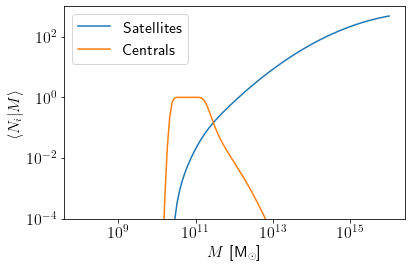

In [6]:
fig, ax = plt.subplots()
ax.loglog(mass_arr, Ns, label='Satellites')
ax.loglog(mass_arr, Nc, label='Centrals')
ax.set_ylim([1e-4, 1e3])
ax.legend()
ax.set_xlabel('$M$ [M$_\odot$]')
ax.set_ylabel(r'$\langle N_i|M \rangle$')
fig.tight_layout()
plt.show()